In [1]:
#Code sourced from github: roysuman088/quantum-edge-detection.ipynb and Quantum-Hadamard-Edge-detection/QC_QHED.ipynb
#We updated the parts that use qiskit to be compatible and run with v 1.0.2
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

In [2]:
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
from qiskit.providers import *
from qiskit import QuantumCircuit

print(qiskit.__version__)

1.0.2


Create a simple image as a numpy array

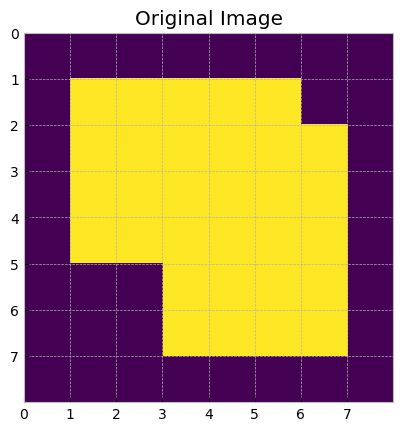

In [3]:
#8x8 pixel image
image = np.array([ [0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0] ])

# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

plot_image(image, 'Original Image')

Normilize intensity values to be used as a statevector

In [4]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):

    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            if rms==0:
                image_norm.append(0)
            else:
                image_norm.append(ele / rms)

    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

Create quantum circuit with gates and impliment starting image state

In [5]:
#Initialize some global variable for number of qubits
n = 6 #6 qubits for 64 pixel image [need log_2(N) qubits where N is number of pixels]
data_qb = n 
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize unitary shifting matrix
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


In [6]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw(fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw(fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

#circuits for both horizontal and vertical edges.
#Iamge state is encoded in qubits 1-6 and haramond is applied to q0 to compute differences in intesisty

┌───┐                                                                                                                                                                   ┌──────────┐┌───┐
q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0         ├┤ H ├
     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐│          │└───┘
q_1: ┤0                                                                                                                                                                                                                                                                                                                                       ├┤1         ├─────
     │                                                                                                                                                                                                                                                                                                                                        ││          │     
q_2: ┤1                                                                                                                                                                                                                                                                                                                                       ├┤2         ├─────
     │                                                                                                                                                                                                                                                                                                                                        ││          │     
q_3: ┤2                                                                                                                                                                                                                                                                                                                                       ├┤3 Unitary ├─────
     │  Initialize(0,0,0,0,0,0,0,0,0,0.17961,0.17961,0.17961,0.17961,0.17961,0,0,0,0.17961,0.17961,0.17961,0.17961,0.17961,0.17961,0,0,0.17961,0.17961,0.17961,0.17961,0.17961,0.17961,0,0,0.17961,0.17961,0.17961,0.17961,0.17961,0.17961,0,0,0,0,0.17961,0.17961,0.17961,0.17961,0,0,0,0,0.17961,0.17961,0.17961,0.17961,0,0,0,0,0,0,0,0,0) ││          │     
q_4: ┤3                                                                                                                                                                                                                                                                                                                                       ├┤4         ├─────
     │                                                                                                                                                                                                                                                                                                                                        ││          │     
q_5: ┤4                                                                                                                                                                                                                                                                                     

┌───┐                                                                                                                                                                   ┌──────────┐┌───┐
q_0: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ H ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0         ├┤ H ├
     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┴───┴──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐│          │└───┘
q_1: ┤0                                                                                                                                                                                                                                                                                                                                       ├┤1         ├─────
     │                                                                                                                                                                                                                                                                                                                                        ││          │     
q_2: ┤1                                                                                                                                                                                                                                                                                                                                       ├┤2         ├─────
     │                                                                                                                                                                                                                                                                                                                                        ││          │     
q_3: ┤2                                                                                                                                                                                                                                                                                                                                       ├┤3 Unitary ├─────
     │  Initialize(0,0,0,0,0,0,0,0,0,0.17961,0.17961,0.17961,0.17961,0,0,0,0,0.17961,0.17961,0.17961,0.17961,0,0,0,0,0.17961,0.17961,0.17961,0.17961,0.17961,0.17961,0,0,0.17961,0.17961,0.17961,0.17961,0.17961,0.17961,0,0,0.17961,0.17961,0.17961,0.17961,0.17961,0.17961,0,0,0,0.17961,0.17961,0.17961,0.17961,0.17961,0,0,0,0,0,0,0,0,0) ││          │     
q_4: ┤3                                                                                                                                                                                                                                                                                                                                       ├┤4         ├─────
     │                                                                                                                                                                                                                                                                                                                                        ││          │     
q_5: ┤4                                                                                                                                                                                                                                                                                     

Computing the vectors with intensity differences of adjacent pixels

In [23]:
# Simulating the cirucits
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', token='back = service.backend(name='simulator_statevector')

from qiskit import transpile
from qiskit.quantum_info import Statevector

state_vectors = []
for circuit in circ_list:
    job = transpile(circuit)
    statevector = Statevector(job)
    state_vectors.append(statevector)

#results = transpile(circ_list)
#print(state_vectors)

sv_h = state_vectors[0]
sv_v = state_vectors[1]

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
#print(np.array(sv_h))
display(array_to_latex(np.array(sv_h)[:30], max_size=30))
print()
print('Vertical scan statevector:')
display(array_to_latex(np.array(sv_v)[:30], max_size=30))
print(len(sv_v))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

128


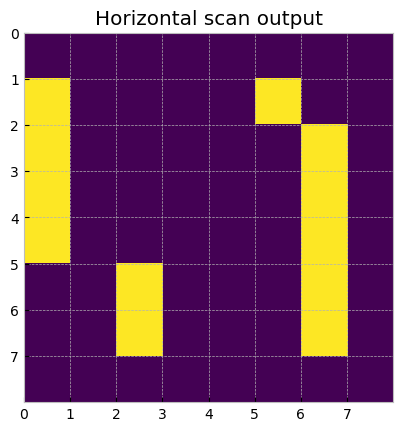

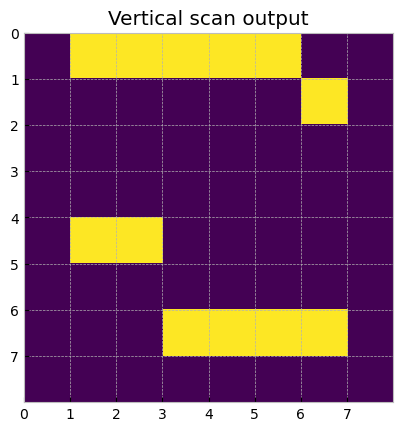

In [44]:
# Classical postprocessing for plotting the output

# Defining a lambda function for threshold of binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 8^2 to an 8x8 matrix so that they represent the graph of the image
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

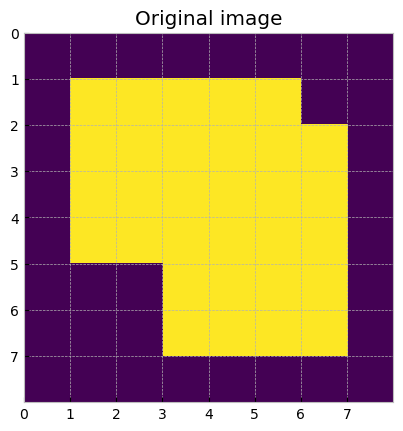

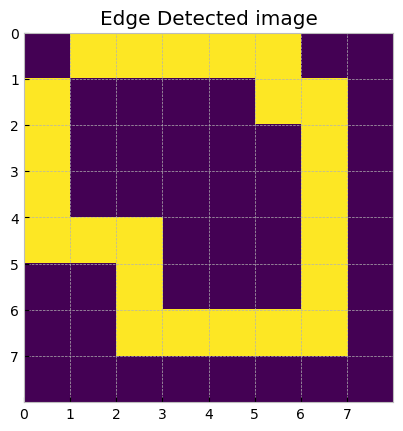

In [45]:
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

We now used a real image that is 32x32 pixels. The steps are nearly identical for the small image but use more qubits to store the data.

Raw Image info: (32, 32, 4)
Raw Image datatype: uint8
Image shape (numpy array): (32, 32)


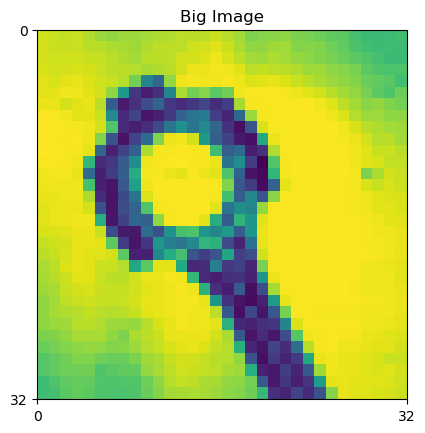

In [136]:
## With an actual image
from PIL import Image
style.use('default')

image_size = 32       # Original image-width
image_crop_size = 8   # Width of each part of image for processing

image_raw = np.array(Image.open('wrench_for_edge_detection_32.png'))

print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)

# Convert the RBG component of the image to B&W image, as a numpy array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)

image = np.array(image)
print('Image shape (numpy array):', image.shape)

plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [137]:
#encode the intensities of image pixels as probability amplitudes of quantum states useing normalization 
# Convert the raw pixel values to probability amplitudes

def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms_32 = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms_32)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

#normalize image and get coefficients in both horizontal and vertical directions

# Horizontal: Original image
h_norm_image_32 = amplitude_encode(image)
print("Horizontal image normalized coefficients",h_norm_image_32)
print()
print()
# Vertical: Transpose of Original image
v_norm_image_32 = amplitude_encode(image.T)
print("vertical image normalized coefficients",v_norm_image_32)
print()
print("size of 1d array",h_norm_image_32.shape)
print("size of 1d array",v_norm_image_32.shape)

Horizontal image normalized coefficients [0.03440694 0.0341178  0.03382867 ... 0.03484064 0.03469607 0.03426237]


vertical image normalized coefficients [0.03440694 0.0345515  0.03469607 ... 0.03469607 0.03440694 0.03426237]

size of 1d array (1024,)
size of 1d array (1024,)


In [138]:
# Initialize some global variable for number of qubits
data_qb_32 = 10
anc_qb_32 = 1
total_qb_32 = data_qb_32 + anc_qb_32

#larger unitary shift matrix
D2n_1 = np.roll(np.identity(2**total_qb_32), 1, axis=1)

In [139]:
# Creating the circuit for horizontal scan
qc_h_32 = QuantumCircuit(total_qb_32)
qc_h_32.initialize(h_norm_image_32, range(1, total_qb_32))
qc_h_32.h(0)
qc_h_32.unitary(D2n_1, range(total_qb_32))
qc_h_32.h(0)

display(qc_h_32.draw(fold=-1))

# Create the circuit for vertical scan
qc_v_32 = QuantumCircuit(total_qb_32)
qc_v_32.initialize(v_norm_image_32, range(1, total_qb_32))
qc_v_32.h(0)
qc_v_32.unitary(D2n_1, range(total_qb_32))
qc_v_32.h(0)

display(qc_v_32.draw(fold=-1))

# Combine both circuits into a single list
circ_list_32 = [qc_h_32, qc_v_32]

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [145]:
state_vectors_32 = []
for circuit in circ_list_32:
    job = transpile(circuit)
    statevector = Statevector(job)
    state_vectors_32.append(statevector)

#results = transpile(circ_list)
#print(state_vectors)

sv_h_32 = state_vectors_32[0]
sv_v_32 = state_vectors_32[1]

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
#print(np.array(sv_h))
display(array_to_latex(np.array(sv_h_32), max_size=128))
print()
print('Vertical scan statevector:')
display(array_to_latex(np.array(sv_v_32), max_size=128))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

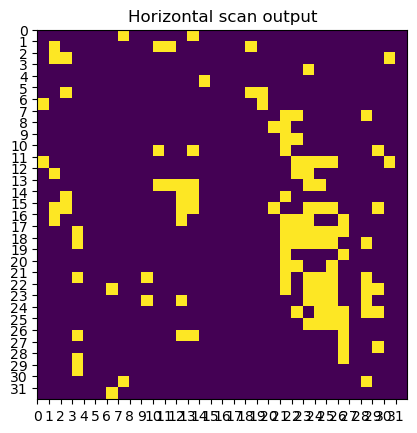

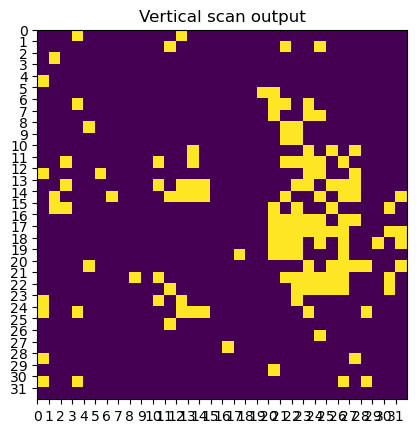

In [151]:
#  postprocessing for plotting the output

threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
h_edge_scan_img_32 = np.abs(np.array([0 if threshold(sv_h_32[2*(i)+1].real) else 1 for i in range(2**data_qb_32)])).reshape(32, 32)
v_edge_scan_img_32 = np.abs(np.array([0 if threshold(sv_v_32[2*(i)+1].real) else 1 for i in range(2**data_qb_32)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(h_edge_scan_img_32, 'Horizontal scan output')
plot_image(v_edge_scan_img_32, 'Vertical scan output')

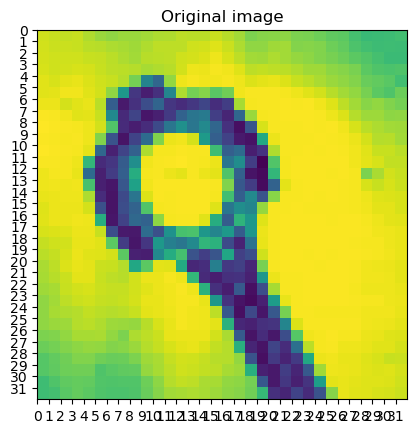

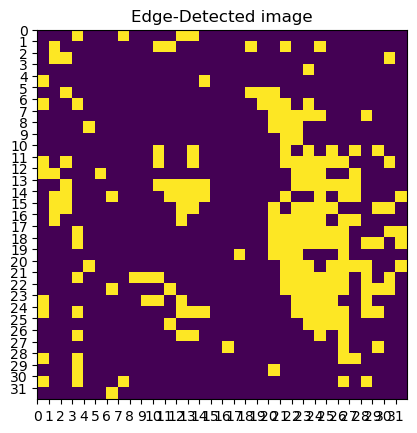

In [153]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image_32 = h_edge_scan_img_32 | v_edge_scan_img_32

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_image_32, 'Edge-Detected image')